# The need for a third dataset


We start off with a toy dataset. Each observation has only two features (variables). This makes it easy to visualise (most montiors are only 2D) and means we will not spend time waiting for the computer to crunch numbers. Most of the intuition we gather from these small datasets transfers directly to larger ones.

Randomly distributed blobs, either red or blue:

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

In [2]:
from sklearn.datasets import make_blobs

labels = ["b", "r"]
X, y = make_blobs(n_samples=400, centers=23, random_state=42)
y = np.take(labels, (y < 10))

The features (or observations) are stored in a two dimensional array named, by convention `X`. The label (the thing we are trying to predict) is stored in a one dimensional array named, by convention, `y`. Let's inspect them in a bit more detail:

In [3]:
X[:5]

array([[ -4.21978613,  -1.71762081],
       [ -8.90204992,   7.78548117],
       [ -2.58120774,  10.01781903],
       [ -8.43029062,  -6.81154662],
       [  9.04375197,   5.06142105]])

In [4]:
y[:5]

array(['b', 'r', 'r', 'r', 'b'],
      dtype='<U1')

Text(0,0.5,'Feature 2')

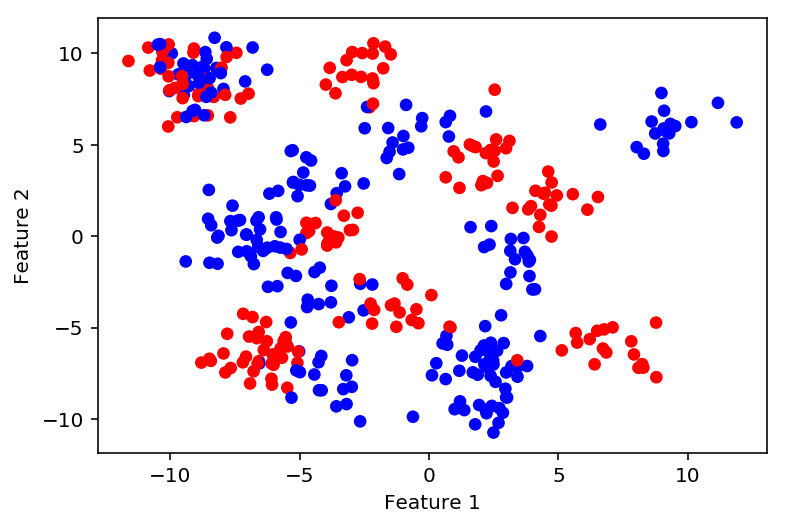

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, lw=0, s=40)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

## Aside on APIs

A short aside on the API that most estimators (classifiers, regressors and transformers) follow. Was pioneered by scikit-learn which adheres strictly to this API. Many libraries copy the API because it is so widely used, sometimes less strict in following it. Some libraries just do their own thing.

In [6]:
# The defacto standard interface used for Python based machine-learning
class Estimator:
    def __init__(self, parameter1):
        """Construct a new Estimator.
        
        All hyper-parameters are passed as constructor
        arguments.
        """
        self.parameter1 = parameter1

    def fit(self, X, y=None):
        """Fit estimator to data."""
        # set state of `self` by learning from `X` (and `y`)
        return self
    
    def predict(self, X):
        """Make predictions for `X`.
        
        An estimator can only make predictions
        after it has been `fit()`.
        """
        # returns predictions for `y` at `X`
        #
        # pass is a Python keyword to signal an empty
        # clause, just here to notebook syntactically valid.
        pass

    def score(self, X, y_true):
        """Compute score using default scorer of the estimator"""
        # returns a score
        pass

What if we received a new observation at `[3., -2.5]`. What would you predict its colour to be?

One good way to make predictions is to look around the neighbourhood of the new point and assign it a label based on its neighbours. This is exactly the strategy of the `KNeighborsClassifier`. Let's do that:

In [6]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X, y)

print(clf.predict([[3., -2.5]]))

['b']


What about at `[3., +2.5]`?

In [7]:
print(clf.predict([[3., +2.5]]))

['r']


If we keep evaluating the classifier at every point in the plane we will end up with a plot like the following. It shows the decision surface of the classifier.

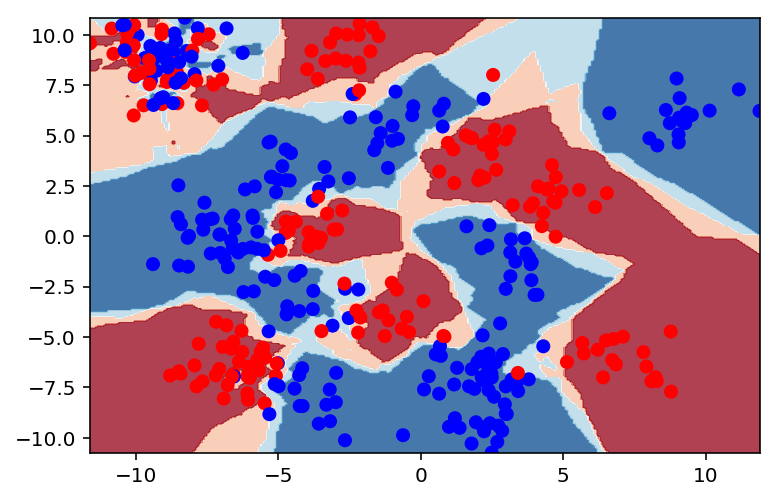

In [8]:
def plot_surface(clf, X, y, n_steps=250, subplot=None, show=True,
                 ylim=None, xlim=None):
    """Plot decision surface of `clf`"""
    if subplot is None:
        fig = plt.figure()
    else:
        plt.subplot(*subplot)

    if xlim is None:
        xlim = X[:, 0].min(), X[:, 0].max()
    if ylim is None:
        ylim = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], n_steps),
                         np.linspace(ylim[0], ylim[1], n_steps))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    z = z.reshape(xx.shape)
    plt.contourf(xx, yy, z, alpha=0.8, cmap=plt.cm.RdBu_r)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlim(*xlim)
    plt.ylim(*ylim)


plot_surface(clf, X, y)

---

## Model complexity

The kNN model has many parameters that need "fitting" during the training as it memorises the whole dataset. In the case of `n_neighbors=1` it fits one parameter for each training point. As `n_neighbors` increases the number of parameters reduces.

As you **increase** `n_neighbors` you **decrease** the model complexity. When considering only the nearest neighbour your model has as many free parameters as there are training examples. This is a very complex model. At the opposite end of the spectrum a model with `n_neighbors=n_samples` has only one parameter, it will always predict the average of all training examples.

What about the `n_neighbors` parameter? Is that not a parameter? Yes and no. It is not a parameter in the same sense as the $\beta_i$s in a linear model. Instead it is a hyper-parameter, it influences the "kind of model" you are fitting to your data.

# Train, validation and test

Why do we need to have three splits?

In [9]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

data = load_breast_cancer()
X, y = data.data, data.target
X = scale(X)

In [10]:
# Split your data into two datasets. "trainval" and "test"
# The test dataset should be put on a USB drive, locked in
# a safe and deleted from your laptop. Only unlock it once
# you have frozen *every* parameter and made all choices.
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=1)

# The training and validation dataset is what we will use
# day to day to tune our model.
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, random_state=2)

In [11]:
knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

print("Train: {:.3f}".format(knn.score(X_train, y_train)))
print("Validation: {:.3f}".format(knn.score(X_val, y_val)))
print("Test: {:.3f}".format(knn.score(X_test, y_test)))

Train: 0.984
Validation: 0.972
Test: 0.965


Now we have split the data into three groups, but why? We have a **train**, **validation** and **test** data set.

So far we always fit our classifier on the **train** set, and measured performance on the **test** set. Now we split the **train** data into two smaller sets again and call them **train** and **validation**.

---

For a moment let's pretend there is no **test** set anymore. If you like we could pretend that our train and validation set could be renamed train and test. Keeping the namign straight and
communicating it to others takes discipline so I recommend not to rename them.

We will fit our model on the **train** dataset, trying different techniques for increasing the accuracy. We know we need to use a different dataset to measure our performance, so we will use the **validation** set to do that. Once we know the technique which has the highest score we will use that for future data.

*Note:* This is an example for you to learn from, so we want to use different "techniques" that actually all have the same performance. This way we know that any difference we see must be due to random fluctuations.

Let's simulate 1000 different attempts to fit a model and select the one with the best validation score. Just like we learnt.

In [12]:
val = []
test = []
for i in range(1000):
    rng = np.random.RandomState(i)
    # think of this as tuning a hyper-parameter
    # a weird parameter but let's just roll with it
    noise = rng.normal(scale=.1, size=X_train.shape)

    knn = KNeighborsClassifier(n_neighbors=3)
    # add noise to our dataset and fit the classifier
    knn.fit(X_train + noise, y_train)

    val.append(knn.score(X_val, y_val))
    test.append(knn.score(X_test, y_test))

print("Validation: {:.3f}".format(np.max(val)))

Validation: 0.991


Wow! We managed to get a perfect score on data not used in the training! This must be a magical algorithm. Not so fast ...

You see that we can overfit the validation set by doing this. Luckily we have the third dataset (the test set) to get an unbiased estimate of the models performance. It checks out as the model fitted on a noisy dataset is no better than any other.


In [13]:
print("Test: {:.3f}".format(test[np.argmax(val)]))

Test: 0.958


The take away is that if you try enough (random) settings you will find one that performs very well on your test set. However because you look at the test set score while choosing the parameters the score is no longer an unbiased estimate of your algorithms performance on unseen data. However this is the number you and everyone else wants to know!

## The full pipeline

This is a full example of how you would pick the best value for `n_neighbors`, make optimal use of your dataset, and obtain a prediction for your generalisation error.

It looks simple and straightforward. It is. However the most frequent source of mistakes in real world problems is "information leakage" of some form or another. When this happens the performance estimates become biased and essentially useless.

In [15]:
from sklearn.model_selection import cross_val_score

data = load_breast_cancer()
X, y = data.data, data.target

neighbors = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

cross_val_scores = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    # this function performs a loop of splitting the data,
    # fitting one split, evaluating on the others
    scores = cross_val_score(knn, X_train, y_train, cv=10)
    cross_val_scores.append(np.mean(scores))

print("best cross-validation score: {:.3f}".format(np.max(cross_val_scores)))
best_n_neighbors = neighbors[np.argmax(cross_val_scores)]

print("best n_neighbors: {}".format(best_n_neighbors))

knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)
print("test-set score: {:.3f}".format(knn.score(X_test, y_test)))

best cross-validation score: 0.944
best n_neighbors: 3
test-set score: 0.909


And preprocessing steps you want to perform need to be performed inside the cross-validation loop. Checkout scikit-learn's `Pipeline` to make this nice and easy to use.

The above `for`-loop works for one parameter but what if we wanted to tune two parameters?
We would end up having to loop over both parameters with two `for`-loops. For three we would have to write three loops, etc. This is such a common task that scikit-learn has some builtin tools for this.

In [16]:
from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# set of parameters we want to try
param_grid = {'n_neighbors':  np.arange(1, 15, 2)}

grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: 0.934
best parameters: {'n_neighbors': 7}
test-set score: 0.951


Because the score on the validation set is a random variable it will fluctuate low and high as we try different classification techniques. This means if you try enough different techniques you will end up picking one which "gets lucky" on the dataset you use to measure performance.

This means that the performance on the validation set is not an unbiased estimate of the generalisation error. Instead we need to have yet another data set that we did not look at during the optimisation process and use that to estimate the performance on future data.

Great visual guide to parameter tuning and the bias-variance trade-off:

http://www.r2d3.us/visual-intro-to-machine-learning-part-2/

---

## Bonus: Bias-Variance trade-off

It can be shown that the best method for making a prediction $\hat y$ at $x$ is to predict the average of all training examples for which $X = x$. When "best" is defined by the average squared error. In practice there is at most one training point at each $x$. In practice this means we settle for:
$$
\hat f(x) = \mathrm{Ave}\left(y_i \mid x_i \in N_k(x)\right)
$$
where $N_k(x)$ is the neighbourhood containing $k$ points from $\mathcal{T}$ nearest to $x$. This is exactly what kNN does. So why not use it always and for everything?

The curse of dimensionality: as the number of dimensions increases you need an exponentially larger number of training samples to keep $k$ constant.

By making assumptions about the (local) shape of the function we are trying to model we can counteract this and get more stable predictions.

Lienar regression assumes that $f(x)$ is well approximated by a globally linear function.

In contrast kNN assumes that $f(x)$ is well approximated by a locally constant function.

The latter is more flexible, but you have to pay a price for this flexibility. If you do not need the flexibility you can obtain a more stable estimate by making more assumptions.

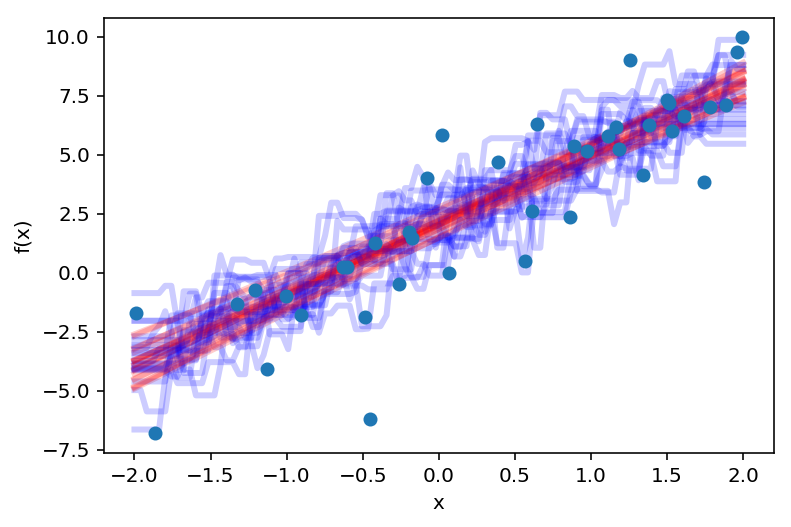

In [17]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression


def non_linear_f(x):
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def linear_f(x, beta0=2.19, beta1=3.141):
    rng = np.random.RandomState()
    return beta0 + beta1 * x + rng.randn(x.shape[0]) * 2.


def make_linear_data():
    x = np.linspace(-2, 2, 1000)
    rng = np.random.RandomState()
    rng.shuffle(x)
    X = np.sort(x[:40])
    y = linear_f(X)

    X = X.reshape(-1, 1)
    return X, y


def make_nonlinear_data():
    x = np.linspace(-2, 2, 1000)
    rng = np.random.RandomState()
    rng.shuffle(x)
    X = np.sort(x[:40])
    y = non_linear_f(X)

    X = X.reshape(-1, 1)
    return X, y


# show a noisy but linear data set, compare variance of kNN with linear regression
line = np.linspace(-2, 2, 100).reshape(-1, 1)

for n in range(20):
    X, y = make_linear_data()
    rgr = LinearRegression()
    rgr.fit(X, y)
    plt.plot(line, rgr.predict(line), '-r', alpha=0.2, label='linear model', lw=3)
    
    rgr = KNeighborsRegressor(n_neighbors=3)
    rgr.fit(X, y)
    plt.plot(line, rgr.predict(line), '-b', alpha=0.2, label='kNN', lw=3)
    #break

plt.plot(X, y, 'o', label='true f(x)')
plt.xlabel('x')
plt.ylabel("f(x)");
#plt.legend(loc='best');

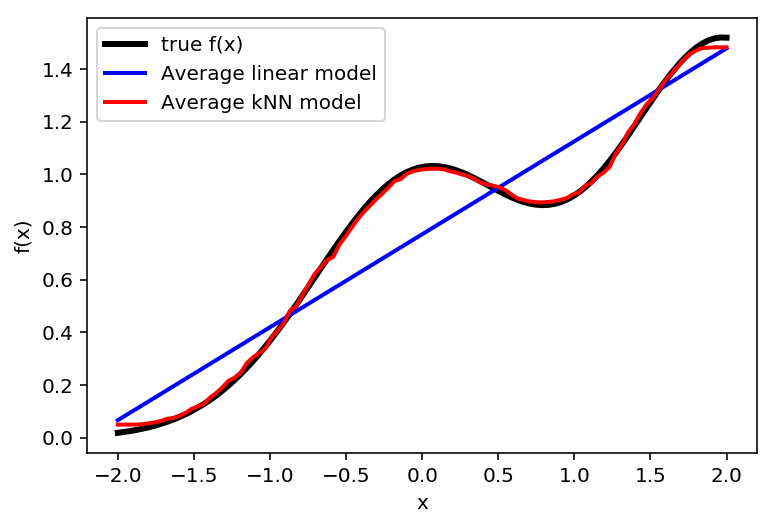

In [18]:
# use a **non linear** data set, compare bias of kNN with linear regression
plt.plot(line, non_linear_f(line), 'k-', lw=3, label='true f(x)')
linear = []
knn = []
for n in range(20):
    X, y = make_nonlinear_data()
    rgr = LinearRegression()
    rgr.fit(X, y)
    linear.append(rgr.predict(line))
    
    rgr = KNeighborsRegressor(n_neighbors=3)
    rgr.fit(X, y)
    knn.append(rgr.predict(line))

plt.plot(line, np.array(linear).mean(axis=0), '-b', lw=2, label='Average linear model')
plt.plot(line, np.array(knn).mean(axis=0), '-r', lw=2, label='Average kNN model');
plt.legend(loc='best');
plt.xlabel('x');
plt.ylabel('f(x)');